<a href="https://colab.research.google.com/github/yashbelhe/11785-Adversarial-Detection/blob/master/SecondaryClassifier_Yash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [145]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from scipy.fftpack import dct
from PIL import Image

def dct2(a):
    return dct( dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return idct( idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

In [147]:
!pip install torch-dct

In [0]:
import torch_dct as dct
from math import floor
class RandomDCTDrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, prob):
        self.prob = prob


    def __call__(self, img):
        dct_img = dct.dct_2d(img)
        # dct_img_r = dct.dct_2d(img[0,:,:])
        # dct_img_g = dct.dct_2d(img[1,:,:])
        # dct_img_b = dct.dct_2d(img[2,:,:])

        C, H, W = dct_img.shape
        # H, W = dct_img_r.shape

        mask = torch.zeros((H,W), dtype = bool)

        # num_coeff = floor(self.prob*H*W)

        # indices = np.random.randint(0,32,(int(num_coeff),2))
        # indices = torch.randperm(H*W)[:num_coeff]
        mask = torch.FloatTensor(H, W).uniform_() > self.prob

        dct_img[:, mask] = 0
        # dct_img_r[mask] = 0
        # dct_img_g[mask] = 0
        # dct_img_b[mask] = 0
        # for i in range(len(indices)):
        #     h = indices[i] % W
        #     w = indices[i] // W
        #     dct_img_r[h,w] = 0
        #     dct_img_g[h,w] = 0
        #     dct_img_b[h,w] = 0
        
        # img_r = dct.idct_2d(dct_img_r)
        # img_g = dct.idct_2d(dct_img_g)
        # img_b = dct.idct_2d(dct_img_b)

        # dct_img = torch.stack([dct_img_r, dct_img_g, dct_img_b], dim=0)
        img_mod = dct.idct_2d(dct_img)
        return img_mod

In [150]:
 normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
# The argumet to DCTDrop is the probablility of keeping each coefficient
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        RandomDCTDrop(0.6),
        normalize,
    ]), download=True),
    batch_size=128, shuffle=True,
    num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False,
    num_workers=4, pin_memory=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])
torch.Size([3, 32, 32])


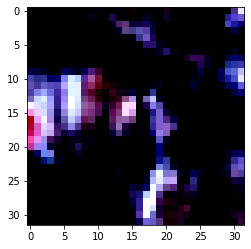

In [151]:
import matplotlib.pyplot as plt
%matplotlib inline

for img, label in train_loader:
    break;
print(img.shape)
# mean=torch.Tensor([0.485, 0.456, 0.406])
# std=torch.Tensor([0.229, 0.224, 0.225])
im = img[1]
print(im.shape)
# im = im*std + mean
plt.imshow(im.numpy().transpose(1,2,0))

In [152]:
!git clone https://github.com/akamaster/pytorch_resnet_cifar10

fatal: destination path 'pytorch_resnet_cifar10' already exists and is not an empty directory.


In [0]:
# !wget https://github.com/akamaster/pytorch_resnet_cifar10/raw/master/pretrained_models/resnet20-12fca82f.th

In [154]:
from pytorch_resnet_cifar10.resnet import *

model = torch.nn.DataParallel(resnet20())
model.cuda()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [0]:
optimizer = torch.optim.SGD(model.parameters(), 0.1,
                                momentum=0.9,
                                weight_decay=5e-4)
criterion = nn.CrossEntropyLoss().cuda()
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
#                                                         milestones=[100, 150], last_epoch=0)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                        milestones=[100, 150])
print_freq = 50

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:

def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        input_var = input.cuda()
        target_var = target

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))

In [0]:
def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))

    return top1.avg

In [0]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)
    

In [0]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


In [0]:
best_prec1 = 0
for epoch in range(0, 200):

        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        train(train_loader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        if epoch > 0 and epoch % 10 == 0:
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
            }, is_best, filename=os.path.join('/content/gdrive/My Drive/', 'checkpoint.th'))

        save_checkpoint({
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best, filename=os.path.join('', 'model.th'))


current lr 1.00000e-01
Epoch: [0][0/391]	Time 0.742 (0.742)	Data 0.691 (0.691)	Loss 3.4488 (3.4488)	Prec@1 10.938 (10.938)
Epoch: [0][50/391]	Time 0.173 (0.196)	Data 0.146 (0.161)	Loss 2.2231 (2.5160)	Prec@1 19.531 (15.119)
Epoch: [0][100/391]	Time 0.040 (0.189)	Data 0.000 (0.153)	Loss 2.0133 (2.3113)	Prec@1 20.312 (17.922)
Epoch: [0][150/391]	Time 0.517 (0.187)	Data 0.480 (0.152)	Loss 1.9948 (2.2188)	Prec@1 27.344 (19.511)
Epoch: [0][200/391]	Time 0.178 (0.183)	Data 0.143 (0.148)	Loss 1.8339 (2.1463)	Prec@1 28.125 (21.156)
Epoch: [0][250/391]	Time 0.433 (0.182)	Data 0.388 (0.148)	Loss 1.7911 (2.0890)	Prec@1 30.469 (22.887)
Epoch: [0][300/391]	Time 0.030 (0.182)	Data 0.000 (0.147)	Loss 1.9109 (2.0449)	Prec@1 27.344 (24.398)
Epoch: [0][350/391]	Time 0.033 (0.181)	Data 0.000 (0.146)	Loss 1.7335 (2.0024)	Prec@1 34.375 (25.757)
Test: [0/79]	Time 0.259 (0.259)	Loss 1.6349 (1.6349)	Prec@1 38.281 (38.281)
Test: [50/79]	Time 0.010 (0.023)	Loss 1.6248 (1.7661)	Prec@1 35.938 (34.145)
 * Prec@1 3

In [0]:
save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
            }, is_best, filename=os.path.join('/content/gdrive/My Drive/', 'checkpoint_final_dct_drop.th'))